In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import U1,U2,U3 #IBMQの基底ゲート

from fractions import Fraction

## 理想的な回路作成

In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('$2^5$個のデータ')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.show()

###　動作の確認
初期状態$|0 \cdots 0\rangle$を作成

In [3]:
# 全体のパラメータ
nqubits = 3
times = 4

In [4]:
import matplotlib.ticker as ticker
state1 = QuantumState(nqubits)
state1.set_zero_state()

次にアダマールゲートを作成する
$$
H = \frac{1}{\sqrt{2}}(|0\rangle \langle 0 | + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

In [5]:
def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

このアダマールゲートを初期状態$|00 \cdots 00\rangle$に作用させる。
$$
|s\rangle = (H\otimes \cdots \otimes H)|0 \cdots 0 \rangle \\
= \frac{1}{(\sqrt{2})^n}(|0\rangle + |1\rangle)\otimes \cdots \otimes (|0\rangle + |1\rangle) \\
= \frac{1}{(\sqrt{2})^n}(|00 \cdots 00\rangle + |00\cdots 01\rangle + \cdots + |11 \cdots 10\rangle + |11\cdots 11\rangle)|s\rangle \\
= \frac{1}{(\sqrt{2})^n}\sum^{2^n - 1}_{x = 0} |x\rangle
$$

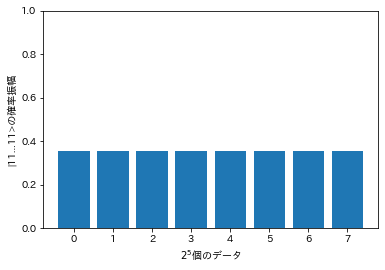

In [6]:
Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state1)

show_distribution(state1, nqubits)

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。

$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

In [7]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [8]:
fuga = state1.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
# print(fuga.get_vector())
print(fuga)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
(-0.353553,0)



最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

In [9]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

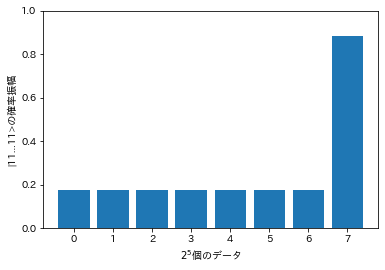

In [10]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state1)
U_s.update_quantum_state(state1)
show_distribution(state1, nqubits)

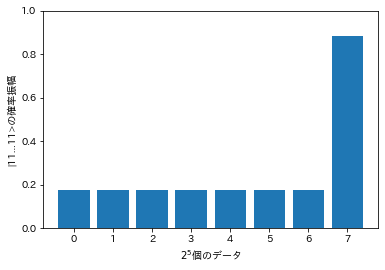

0.8838834764831837


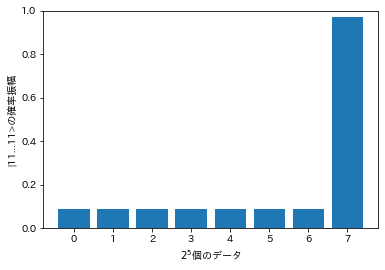

0.9722718241315015


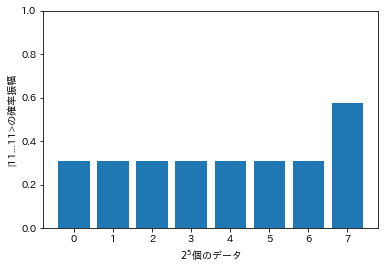

0.5745242597140687


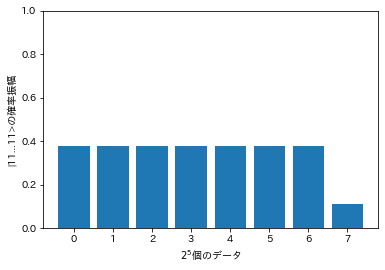

0.11048543456039785


In [11]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state1 = QuantumState(nqubits)
state1.set_zero_state()

Hadamard.update_quantum_state(state1)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    show_distribution(state1, nqubits)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785


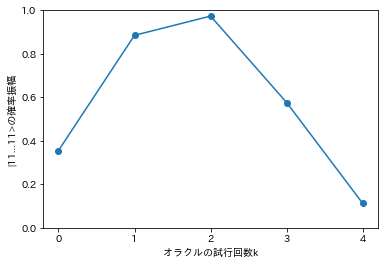

In [12]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

avg_result = []
hoge = np.linalg.norm(inner_product(state1, target_state))
avg_result.append(hoge)
for i in range(times):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.xlabel('オラクルの試行回数k')
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 5, step=1))
plt.plot(avg_result, "o-")

In [13]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 5, step=1))
    plt.show()

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785
maximal probability 9.722718e-01 is obtained at k = 2


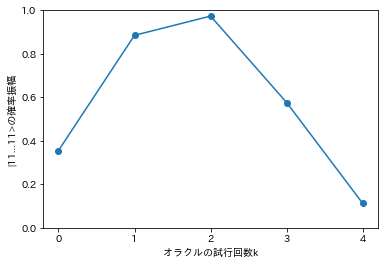

In [14]:
grover(nqubits, times)


## 任意の回転ゲート
任意の回転ゲートでアダマール演算子を作成する

Qulacsでは任意の回転ゲートを作成する際に、IBMQのOpenQASMを使用する。

以下のコードは、
`U3(対象ビットの添字, \theta, \psi, \lambda)`となっている。
[参考資料](http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id24)
また、対象ビットの添字はQulacsの仕様上、$|00 \cdots 00\rangle$である場合、一番右から0番目の量子ビットになる
[参考資料](https://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html?highlight=%E5%AF%BE%E8%B1%A1%E3%83%93%E3%83%83%E3%83%88%E3%81%AE%E6%B7%BB%E3%81%88%E5%AD%97#id3)

$$
U(\theta, \phi, \lambda) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -e^{i \lambda} \sin{\frac{\theta}{2}} \\
e^{i \phi}\cos{\frac{\theta}{2}} & e^{i (\lambda + \phi)}\cos{\frac{\theta}{2}}
\end{pmatrix}
$$

In [20]:
from qulacs.gate import U3
print(U3(0, np.pi/2, 0, np.pi))

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
           (0.707107,0) (0.707107,-8.65956e-17)
           (0.707107,0) (-0.707107,8.65956e-17)



### 任意の回転ゲートを利用してアダマールゲートを作成
上記の内容を踏まえてアダマールゲートを作成する。
$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\\
= \begin{pmatrix}
\cos{\frac{\pi}{4}} & -e^{i \pi} \sin{\frac{\pi}{4}} \\
e^{i 0}\cos{\frac{\pi}{4}} & e^{i (\pi + 0)}\cos{\frac{\pi}{4}}
\end{pmatrix} \\
= U(\frac{\pi}{2}, 0, \pi)
$$
これを用いて、以下のように作成する。


In [16]:
def make_revolution_Hadamard(nqubits):
    U_3 = QuantumCircuit(nqubits)
    THETA = np.pi/2
    PHI = 0
    LAMBDA = np.pi
    # 全てのqubitにゲートを作用
    for i in range(nqubits):
        control_index = i
        U_3.add_gate(U3(control_index, THETA, PHI, LAMBDA))
    return U_3

試しに、通常のアダマール演算子と比較してみる。

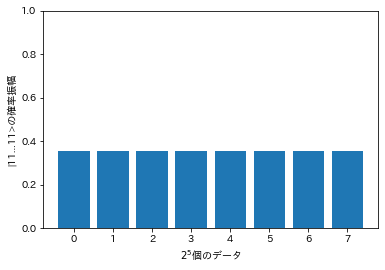

1.5707963267948966
3.141592653589793
3.141592653589793
0
1
2


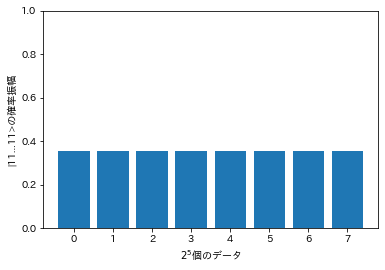

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


In [17]:
# 通常のアダマール演算子を作成し、 初期化した3量子ビットに作用
Hadamard = make_Hadamard(3)
state1 = QuantumState(3)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)
show_distribution(state1, 3)

# アダマール演算子と同じ振る舞いをするよう作成した回転ゲートを、
# 初期化した3量子ビットに作用
revolution_Hadamard = make_revolution_Hadamard(3)
state2 = QuantumState(3)
state2.set_zero_state()
revolution_Hadamard.update_quantum_state(state2)
show_distribution(state2, 3)

print(state1.get_vector())
print(state2.get_vector())


どのくらいの誤差があるか調べる。

In [21]:
state1.get_vector() == state2.get_vector()
# 誤差
absolute_error_array = []
relative_error_array = []
for i in range(len(state1.get_vector())):
    absolute_error = state2.get_vector()[i] - state1.get_vector()[i]
    absolute_error_array.append(absolute_error)
    relative_error = absolute_error / state1.get_vector()[i]
    relative_error_array.append(relative_error)

print(f'絶対誤差：{absolute_error_array}')
print(f'相対誤差：{relative_error_array}')


絶対誤差：[(0.14644660940672644+0j), (-0.3535533905932737+0j), (0.14644660940672632+0j), (-0.3535533905932737+0j), (0.14644660940672632+0j), (-0.3535533905932737+0j), (0.1464466094067262+0j), (-0.3535533905932737+0j)]
相対誤差：[(0.4142135623730957+0j), (-1+0j), (0.41421356237309537+0j), (-1+0j), (0.41421356237309537+0j), (-1+0j), (0.4142135623730951+0j), (-1+0j)]
